# HW03 (due October 12th)

Goal: estimate the effect of Union status on hours worked

# Load Data

In [1]:
// Load the NLSY dataset
webuse nlswork, clear

grstyle init
grstyle set plain, horizontal grid


(National Longitudinal Survey.  Young Women 14-26 years of age in 1968)




In [2]:
de


Contains data from https://www.stata-press.com/data/r16/nlswork.dta
  obs:        28,534                          National Longitudinal Survey.
                                                Young Women 14-26 years of age
                                                in 1968
 vars:            21                          27 Nov 2018 08:14
--------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------
idcode          int     %8.0g                 NLS ID
year            byte    %8.0g                 interview year
birth_yr        byte    %8.0g                 birth year
age             byte    %8.0g                 age in current year
race            byte    %8.0g      racelbl    race
msp             byte    %8.0g                 1 if married, spouse present
nev_mar         byte    %8.0g

#  Summary statistics

In [3]:
// Summarize the dataset
su


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
      idcode |     28,534    2601.284    1487.359          1       5159
        year |     28,534    77.95865    6.383879         68         88
    birth_yr |     28,534    48.08509    3.012837         41         54
         age |     28,510    29.04511    6.700584         14         46
        race |     28,534    1.303392    .4822773          1          3
-------------+---------------------------------------------------------
         msp |     28,518    .6029175    .4893019          0          1
     nev_mar |     28,518    .2296795    .4206341          0          1
       grade |     28,532    12.53259    2.323905          0         18
    collgrad |     28,534    .1680451    .3739129          0          1
    not_smsa |     28,526    .2824441    .4501961          0          1
-------------+-------------------------------------------------

In [4]:
// tabulate college and union status
tab collgrad union


      1 if |
   college |      1 if union
  graduate |         0          1 |     Total
-----------+----------------------+----------
         0 |    12,067      3,413 |    15,480 
         1 |     2,661      1,097 |     3,758 
-----------+----------------------+----------
     Total |    14,728      4,510 |    19,238 


In [5]:
// generate a variable for log hours worked
gen hours_log = log(hours)

(67 missing values generated)


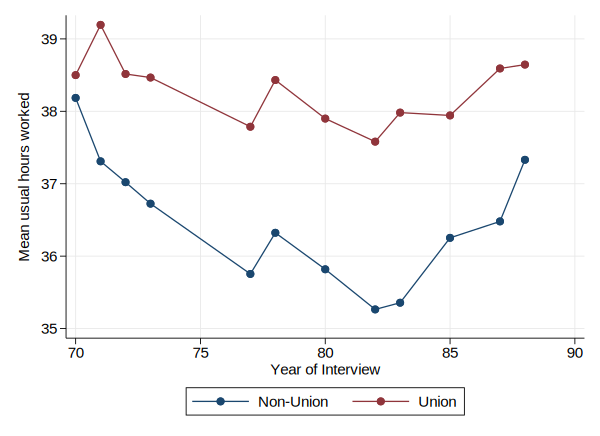

In [12]:
// plot log hours against year separately for union and non-union

lgraph hours year union, legend(on order(1 "Non-Union" 2 "Union")) xtitle("Year of Interview")
graph di

# Regression: Effect of union status on hours worked

In [7]:
// Regress hours worked against union status
reg hours_log union


      Source |       SS           df       MS      Number of obs   =    19,202
-------------+----------------------------------   F(1, 19200)     =    147.51
       Model |  24.1358023         1  24.1358023   Prob > F        =    0.0000
    Residual |  3141.51825    19,200  .163620742   R-squared       =    0.0076
-------------+----------------------------------   Adj R-squared   =    0.0076
       Total |  3165.65405    19,201  .164869228   Root MSE        =     .4045

------------------------------------------------------------------------------
   hours_log |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       union |   .0836776   .0068897    12.15   0.000     .0701733    .0971819
       _cons |   3.527044   .0033364  1057.15   0.000     3.520504    3.533583
------------------------------------------------------------------------------


#### Log Hours

Running the regression with the log of the dependent variable allows us to interpret the coefficient in terms of percentage change: <br>
                <center>$log(y)= \beta_0 + \beta_1 x + \varepsilon$ </center><br>
A 1-unit increase in $x$ corresponds to an increase in $log(y)$ by $\hat{\beta}_1$: <br>
                <center>$log(y') - log(y) =\hat{\beta}_1 (x + 1) - \hat{\beta}_1x = \hat{\beta}_1$ <br>
                $e^{\hat{\beta}_1} = \frac{y'}{y} = \frac{y+y'-y}{y} = 1 + \frac{y'-y}{y}$</center>
Therefore, the percentage change in is: <br>
<center>$\frac{y'-y}{y} = e^{\hat{\beta}_1}-1$ </center><br>
For sufficiently small values of $\hat{\beta}_1$: <br> <center>$e^{\hat{\beta}_1}-1\approx\hat{\beta}_1$ </center> <br>

In our example, on average being a union worker is associated with an increase in hours worked by $100\hat{\beta}_1 \approx 8.37\%$ ($100(e^{\hat{\beta}_1}-1)=8.73$)

#### What is the identification assumption for the coefficient on union to be causal?

Assume that there are no variables that affects both hours worked and union status, and that there is no reverse causality (no effect of hours worked on union status). <br><br> The former assumption is unrealistic as there may be many factors, both observable and unobservable, that are correlated with being in a union and with the number of hours worked. For instance, living in a specific city may be correlated both with higher probability of being in a union and with a higher number of hours worked. Thus, the purpose of the following analysis is to <i>clean</i> the effect of union as much as possible

In [8]:
// Regress hours worked against union status with individual (idcode) and year fixed effects
reghdfe hours_log union, absorb(year idcode)

(dropped 667 singleton observations)
(MWFE estimator converged in 7 iterations)

HDFE Linear regression                            Number of obs   =     18,535
Absorbing 2 HDFE groups                           F(   1,  15040) =      73.55
                                                  Prob > F        =     0.0000
                                                  R-squared       =     0.5096
                                                  Adj R-squared   =     0.3957
                                                  Within R-sq.    =     0.0049
                                                  Root MSE        =     0.3112

------------------------------------------------------------------------------
   hours_log |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       union |   .0724377   .0084466     8.58   0.000     .0558813    .0889942
       _cons |   3.532703     .00304  1162.06   0

#### What is the identification assumption for the coefficient on union to be causal?

Differently from before, here we control for factors that are fixed either over time within the same individual (e.g. year of birth) or across individuals within the same year (e.g. the presence of a crisis). Therefore, we <i>only</i> have to assume that there are no variables, varying both over time and across individuals, that are correlated with both hours worked and union status. 

In [9]:
// Now cluster standard errors. 
reghdfe hours_log union, absorb(year idcode) cluster(idcode)

(dropped 667 singleton observations)
(MWFE estimator converged in 7 iterations)

HDFE Linear regression                            Number of obs   =     18,535
Absorbing 2 HDFE groups                           F(   1,   3482) =      48.28
Statistics robust to heteroskedasticity           Prob > F        =     0.0000
                                                  R-squared       =     0.5096
                                                  Adj R-squared   =     0.3957
                                                  Within R-sq.    =     0.0049
Number of clusters (idcode)  =      3,483         Root MSE        =     0.3112

                             (Std. Err. adjusted for 3,483 clusters in idcode)
------------------------------------------------------------------------------
             |               Robust
   hours_log |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       union 

#### What level should you cluster at and why? What do you notice about the coefficients?

Standard errors are clustered at the individual level because this is the level at which the "treatment" is assigned. The coefficient does not change, but the standard errors do

In [10]:
// Now add fixed effects for occupation code

reghdfe hours_log union, absorb(year idcode occ_code) cluster(idcode)


(dropped 666 singleton observations)
(MWFE estimator converged in 16 iterations)

HDFE Linear regression                            Number of obs   =     18,463
Absorbing 3 HDFE groups                           F(   1,   3475) =      33.73
Statistics robust to heteroskedasticity           Prob > F        =     0.0000
                                                  R-squared       =     0.5258
                                                  Adj R-squared   =     0.4149
                                                  Within R-sq.    =     0.0034
Number of clusters (idcode)  =      3,476         Root MSE        =     0.3062

                             (Std. Err. adjusted for 3,476 clusters in idcode)
------------------------------------------------------------------------------
             |               Robust
   hours_log |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       union

#### In terms of causal inference, why is adding occupation code  as a control probably not a good idea?

Occupation is likely to be a collider: the occupation choice may be influenced by both the number of hours worked in that job and the probability of joining a union for workers in that occupation. 

In [11]:
reghdfe hours_log union, absorb(idcode year#c.(race age collgrad msp nev_ma not_smsa c_city south)) cluster(idcode)

(dropped 670 singleton observations)
(MWFE estimator converged in 21 iterations)

HDFE Linear regression                            Number of obs   =     18,510
Absorbing 2 HDFE groups                           F(   1,   3479) =      48.36
Statistics robust to heteroskedasticity           Prob > F        =     0.0000
                                                  R-squared       =     0.5166
                                                  Adj R-squared   =     0.4009
                                                  Within R-sq.    =     0.0050
Number of clusters (idcode)  =      3,480         Root MSE        =     0.3100

                             (Std. Err. adjusted for 3,480 clusters in idcode)
------------------------------------------------------------------------------
             |               Robust
   hours_log |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       union

#### What are "good controls" in the dataset in terms of being exogenous to union status? How do these change your estimates?

All demographic variables (age, race, place of living, etc.) can be considered as good controls as the decision about joining a union cannot affect these variables. The estimate doesn't change by much and, most importantly, the sign is consistent across all specifications hinting towards a positive effect of union status on hours worked. 